<a href="https://colab.research.google.com/github/KNU-BrainAI-Capstone2022/Adam/blob/main/showandtell.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install "git+https://github.com/philferriere/cocoapi.git#egg=pycocotools&subdirectory=PythonAPI"

  Cloning https://github.com/philferriere/cocoapi.git to c:\users\pc\appdata\local\temp\pip-install-pzghfak8\pycocotools_dcb04ef1e43b4580a8c35bf7bacb23e2
  Resolved https://github.com/philferriere/cocoapi.git to commit 2929bd2ef6b451054755dfd7ceb09278f935f7ad
Note: you may need to restart the kernel to use updated packages.


  Running command git clone -q https://github.com/philferriere/cocoapi.git 'C:\Users\PC\AppData\Local\Temp\pip-install-pzghfak8\pycocotools_dcb04ef1e43b4580a8c35bf7bacb23e2'


In [ ]:
import os
import sys
sys.path.append('C:/Users/PC/Desktop/COCO')
from pycocotools.coco import COCO


dataDir = 'C:/Users/PC/Desktop/COCO/data'
dataType = 'train2017'
instances_annFile = os.path.join(dataDir, 'annotations/instances_{}.json'.format(dataType))
coco = COCO(instances_annFile)


captions_annFile = os.path.join(dataDir, 'annotations/captions_{}.json'.format(dataType))
coco_caps = COCO(captions_annFile)


ids = list(coco.anns.keys())

loading annotations into memory...
Done (t=14.67s)
creating index...
index created!
loading annotations into memory...
Done (t=0.95s)
creating index...
index created!


http://images.cocodataset.org/train2017/000000496766.jpg


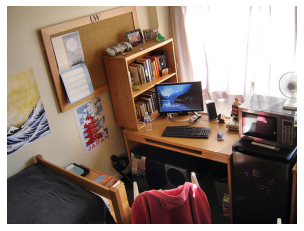

This is someones bedroom in their home. 
We are looking at a small desk under a window in a bedroom.
A tiny college dorm room with a single bed, computer desk, bookshelves, a microwave, and Japanese artwork.
a desk with a computer, mini book shelf and toy on it 
The computer monitor ids sitting atop the student desk.


In [ ]:
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
%matplotlib inline

# pick a random image and obtain the corresponding URL
ann_id = np.random.choice(ids)
img_id = coco.anns[ann_id]['image_id']
img = coco.loadImgs(img_id)[0]
url = img['coco_url']

# print URL and visualize corresponding image
print(url)
I = io.imread(url)
plt.axis('off')
plt.imshow(I)
plt.show()

# load and display captions

annIds = coco_caps.getAnnIds(imgIds=img['id']);
anns = coco_caps.loadAnns(annIds)
coco_caps.showAnns(anns)

In [ ]:
import nltk
import pickle
import os.path
from pycocotools.coco import COCO
from collections import Counter

class Vocabulary(object):

    def __init__(self,
        vocab_threshold, #최소 단어 등장 횟수
        vocab_file="C:/Users/PC/Desktop/COCO/vocab/vocab.pkl",
        start_word="<start>",
        end_word="<end>",
        unk_word="<unk>",
        annotations_file="C:/Users/PC/Desktop/COCO/data/annotations/captions_train2017.json", #train 캡션 원본 파일
        vocab_from_file=False): #train 캡션파일로부터 단어를 얻어내 vocab_file에 저장한다.
        
        
        self.vocab_threshold = vocab_threshold
        self.vocab_file = vocab_file
        self.start_word = start_word
        self.end_word = end_word
        self.unk_word = unk_word
        self.annotations_file = annotations_file
        self.vocab_from_file = vocab_from_file
        self.get_vocab()

    def get_vocab(self):
        """Load the vocabulary from file or build it from scratch."""
        if os.path.exists(self.vocab_file) & self.vocab_from_file:
            with open(self.vocab_file, "rb") as f:
                vocab = pickle.load(f)
                self.word2idx = vocab.word2idx
                self.idx2word = vocab.idx2word
            print("Vocabulary successfully loaded from vocab.pkl file!")
        else:
            self.build_vocab()
            with open(self.vocab_file, "wb") as f:
                pickle.dump(self, f)
        
    def build_vocab(self):
        """Populate the dictionaries for converting tokens to integers 
        (and vice-versa)."""
        self.init_vocab()
        self.add_word(self.start_word)
        self.add_word(self.end_word)
        self.add_word(self.unk_word)
        self.add_captions()

    def init_vocab(self):
        self.word2idx = {}
        self.idx2word = {}
        self.idx = 0

    def add_word(self, word):
        """Add a token to the vocabulary."""
        if not word in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            self.idx += 1

    def add_captions(self):
        """Loop over training captions and add all tokens to the vocabulary 
        that meet or exceed the threshold."""
        coco = COCO(self.annotations_file)
        counter = Counter()
        ids = coco.anns.keys()
        for i, id in enumerate(ids):
            caption = str(coco.anns[id]["caption"])
            tokens = nltk.tokenize.word_tokenize(caption.lower())
            counter.update(tokens)

            if i % 100000 == 0:
                print("[%d/%d] Tokenizing captions..." % (i, len(ids)))

        words = [word for word, cnt in counter.items()
                 if cnt >= self.vocab_threshold]

        for i, word in enumerate(words):
            self.add_word(word)

    def __call__(self, word):
        if not word in self.word2idx:
            return self.word2idx[self.unk_word]
        return self.word2idx[word]

    def __len__(self):
        return len(self.word2idx)

In [ ]:
import nltk
import os
import torch
import torch.utils.data as data
from PIL import Image
from pycocotools.coco import COCO
import numpy as np
from tqdm import tqdm
import random
import json

class CoCoDataset(data.Dataset):
    
    def __init__(self, transform, mode, batch_size, vocab_threshold, vocab_file, start_word, 
        end_word, unk_word, annotations_file, vocab_from_file, img_folder):
        self.transform = transform 
        self.mode = mode 
        self.batch_size = batch_size
        self.vocab = Vocabulary(vocab_threshold, vocab_file, start_word, end_word, unk_word, annotations_file, vocab_from_file)
        self.img_folder = img_folder
        if (self.mode == "train") or (self.mode == "val"):
            self.coco = COCO(annotations_file)
            self.ids = list(self.coco.anns.keys())
            print("Obtaining caption lengths...")
            all_tokens = [nltk.tokenize.word_tokenize(str(self.coco.anns[self.ids[index]]["caption"]).lower())
                            for index in tqdm(np.arange(len(self.ids)))]
            self.caption_lengths = [len(token) for token in all_tokens]
        
        else: 
            test_info = json.loads(open(annotations_file).read())
            self.paths = [item["file_name"] for item in test_info["images"]]
        
    def __getitem__(self, index): 
       
        if (self.mode == "train") or (self.mode == "val"):
            ann_id = self.ids[index] 
            caption = self.coco.anns[ann_id]["caption"]
            img_id = self.coco.anns[ann_id]["image_id"] 
            path = self.coco.loadImgs(img_id)[0]["file_name"]

            
            image = Image.open(os.path.join(self.img_folder, path)).convert("RGB")
            image = self.transform(image)

            
            caption = str(caption).lower() 
            tokens = nltk.tokenize.word_tokenize(caption) 
            caption = []
            caption.append(self.vocab(self.vocab.start_word))
            caption.extend([self.vocab(token) for token in tokens])
            caption.append(self.vocab(self.vocab.end_word))
            caption = torch.Tensor(caption).long()

            
            return image, caption 

       
        else: 
            path = self.paths[index]

            
            PIL_image = Image.open(os.path.join(self.img_folder, path)).convert("RGB") 
            orig_image = np.array(PIL_image)
            image = self.transform(PIL_image)

            
            return orig_image, image 

    def get_indices(self):
        sel_length = np.random.choice(self.caption_lengths)
        all_indices = np.where([self.caption_lengths[i] == sel_length for i in np.arange(len(self.caption_lengths))])[0]
        indices = list(np.random.choice(all_indices, size=self.batch_size))
        return indices

    def __len__(self):
        if (self.mode == "train") or (self.mode == "val"):
            return len(self.ids)
        else:
            return len(self.paths)

In [ ]:
def get_loader(transform,
               mode="train",
               batch_size=1,
               vocab_threshold=None,
               vocab_file="C:/Users/PC/Desktop/COCO/vocab/vocab.pkl",
               start_word="<start>",
               end_word="<end>",
               unk_word="<unk>",
               vocab_from_file=True,
               num_workers=0,
               cocoapi_loc="C:/Users/PC/Desktop/COCO"):
    
    assert mode in ["train", "val", "test"]
   

    
    if mode == "train":
        if vocab_from_file == True:
            assert os.path.exists(vocab_file), "vocab_file does not exist. Change vocab_from_file to False to create vocab_file."
        else:
            assert mode == "train", "To generate vocab from captions file, must be in training mode (mode='train')."
                
        img_folder = os.path.join(cocoapi_loc, "data/train2017/")
        annotations_file = os.path.join(cocoapi_loc, "data/annotations/captions_train2017.json")
    
    if mode == "val":
        assert os.path.exists(vocab_file), "Must first generate vocab.pkl from training data."
        assert vocab_from_file == True, "Change vocab_from_file to True."
        img_folder = os.path.join(cocoapi_loc, "data/val2017/")
        annotations_file = os.path.join(cocoapi_loc, "data/annotations/captions_val2017.json")
        
    if mode == "test":
        assert batch_size == 1, "Please change batch_size to 1 if testing your model."
        assert os.path.exists(vocab_file), "Must first generate vocab.pkl from training data."
        assert vocab_from_file == True, "Change vocab_from_file to True."
        img_folder = os.path.join(cocoapi_loc, "data/test2017/")
        annotations_file = os.path.join(cocoapi_loc, "data/annotations/image_info_test2017.json")

   
    dataset = CoCoDataset(transform=transform,
                          mode=mode,
                          batch_size=batch_size,
                          vocab_threshold=vocab_threshold,
                          vocab_file=vocab_file,
                          start_word=start_word,
                          end_word=end_word,
                          unk_word=unk_word,
                          annotations_file=annotations_file,
                          vocab_from_file=vocab_from_file,
                          img_folder=img_folder)

    if mode == "train":
        
        indices = dataset.get_indices()
        initial_sampler = data.sampler.SubsetRandomSampler(indices=indices)
        data_loader = data.DataLoader(dataset=dataset, 
                                      num_workers=num_workers,
                                      batch_sampler=data.sampler.BatchSampler(sampler=initial_sampler,
                                                                              batch_size=dataset.batch_size,
                                                                              drop_last=False))
    else:
        data_loader = data.DataLoader(dataset=dataset,
                                      batch_size=dataset.batch_size,
                                      shuffle=True,
                                      num_workers=num_workers)

    return data_loader

In [ ]:
import torch
from torchvision import transforms


transform_train = transforms.Compose([ 
    transforms.Resize(256),                          
    transforms.RandomCrop(224),                      # Image에 대해서 data augmentation 
    transforms.RandomHorizontalFlip(),               
    transforms.ToTensor(),                           
    transforms.Normalize((0.485, 0.456, 0.406),      
                         (0.229, 0.224, 0.225))])


vocab_threshold = 5


batch_size = 10


data_loader = get_loader(transform=transform_train,
                         mode='train',
                         batch_size=batch_size,
                         vocab_threshold=vocab_threshold,
                         vocab_from_file=False)

loading annotations into memory...
Done (t=0.88s)
creating index...
index created!
[0/591753] Tokenizing captions...
[100000/591753] Tokenizing captions...
[200000/591753] Tokenizing captions...
[300000/591753] Tokenizing captions...
[400000/591753] Tokenizing captions...
[500000/591753] Tokenizing captions...
loading annotations into memory...
Done (t=0.88s)
creating index...
index created!
Obtaining caption lengths...


100%|███████████████████████████████████████████████████████████████████████| 591753/591753 [00:49<00:00, 12029.58it/s]


In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
from torch.nn import functional as F


class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        
        super(EncoderCNN, self).__init__()
        resnet = models.resnet50(pretrained=True)
        modules = list(resnet.children())[:-1] 
        self.resnet = nn.Sequential(*modules)
        self.embed = nn.Linear(resnet.fc.in_features, embed_size)
        self.bn = nn.BatchNorm1d(embed_size, momentum=0.01)

    def forward(self, images):
        
        with torch.no_grad():
            features = self.resnet(images)
        features = features.view(features.size(0), -1)
        features = self.embed(features)
        features = self.bn(features)
        return features


class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers=1):
        
        super(DecoderRNN, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocab_size)

    def forward(self, features, captions):
        
        captions = captions[:,:-1]
        embeddings = self.embed(captions)
        inputs = torch.cat((features.unsqueeze(1), embeddings), 1)
        hiddens, _ = self.lstm(inputs)
        outputs = self.linear(hiddens)
        return outputs

    def sample(self, inputs, states=None, max_len=20):
       
        sampled_ids = []
        for i in range(max_len):
            hiddens, states = self.lstm(inputs, states)
            outputs = self.linear(hiddens.squeeze(1))
            
            predicted = outputs.argmax(1)
            sampled_ids.append(predicted.item())
            inputs = self.embed(predicted)
            inputs = inputs.unsqueeze(1)
        return sampled_ids

    def sample_beam_search(self, inputs, states=None, max_len=20, beam_width=5):
        
        
        idx_sequences = [[[], 0.0, inputs, states]]
        for _ in range(max_len):
            
            all_candidates = []
            
            for idx_seq in idx_sequences:
                hiddens, states = self.lstm(idx_seq[2], idx_seq[3])
                outputs = self.linear(hiddens.squeeze(1))
                
                log_probs = F.log_softmax(outputs, -1)
                top_log_probs, top_idx = log_probs.topk(beam_width, 1)
                top_idx = top_idx.squeeze(0)
                
                for i in range(beam_width):
                    next_idx_seq, log_prob = idx_seq[0][:], idx_seq[1]
                    next_idx_seq.append(top_idx[i].item())
                    log_prob += top_log_probs[0][i].item()
                    
                    inputs = self.embed(top_idx[i].unsqueeze(0)).unsqueeze(0)
                    all_candidates.append([next_idx_seq, log_prob, inputs, states])
            
            ordered = sorted(all_candidates, key=lambda x: x[1], reverse=True)
            idx_sequences = ordered[:beam_width]
        return [idx_seq[0] for idx_seq in idx_sequences]

In [ ]:
vocab_threshold = 5 #최소 단어 count 수


data_loader = get_loader(transform=transform_train,
                         mode='train',
                         batch_size=batch_size,
                         vocab_threshold=vocab_threshold,
                         vocab_from_file=False)
#vocab_threshold를 5로 했을 때 vocabulary에 매핑된 총 단어 수
print('Total number of tokens in vocabulary:', len(data_loader.dataset.vocab))

loading annotations into memory...
Done (t=0.87s)
creating index...
index created!
[0/591753] Tokenizing captions...
[100000/591753] Tokenizing captions...
[200000/591753] Tokenizing captions...
[300000/591753] Tokenizing captions...
[400000/591753] Tokenizing captions...
[500000/591753] Tokenizing captions...
loading annotations into memory...
Done (t=0.85s)
creating index...
index created!
Obtaining caption lengths...


100%|███████████████████████████████████████████████████████████████████████| 591753/591753 [00:49<00:00, 11962.81it/s]


Total number of tokens in vocabulary: 10321


In [ ]:
import numpy as np
import torch.utils.data as data


indices = data_loader.dataset.get_indices() #랜덤으로 하나의 caption length를 sample화하고 그 length를 가진 index를 불러온다
print('{} sampled indices: {}'.format(len(indices), indices))

new_sampler = data.sampler.SubsetRandomSampler(indices=indices)
data_loader.batch_sampler.sampler = new_sampler

#data_loader로부터 batch를 얻고 batch로부터 image와 caption을 얻을 수 있음
for batch in data_loader:
    images, captions = batch[0], batch[1]
    break
    
print('images.shape:', images.shape)
print('captions.shape:', captions.shape)

10 sampled indices: [461593, 18722, 472666, 519929, 116424, 88532, 81811, 243109, 562659, 58423]
images.shape: torch.Size([10, 3, 224, 224])
captions.shape: torch.Size([10, 17])


In [ ]:
#encoder 부분 implementation
embed_size = 256


encoder = EncoderCNN(embed_size)


if torch.cuda.is_available():
    encoder = encoder.cuda()
    images = images.cuda()

features = encoder(images)

#future shape을 확인하기 위함
print('type(features):', type(features))
print('features.shape:', features.shape)

type(features): <class 'torch.Tensor'>
features.shape: torch.Size([10, 256])


In [ ]:
#decoder 부분 implementation
hidden_size = 512


vocab_size = len(data_loader.dataset.vocab)


decoder = DecoderRNN(embed_size, hidden_size, vocab_size)

if torch.cuda.is_available():
    decoder = decoder.cuda()
    captions = captions.cuda()
#decoder의 output에 대한 shape을 확인하기 위함
outputs = decoder(features, captions)

print('type(outputs):', type(outputs))
print('outputs.shape:', outputs.shape)

type(outputs): <class 'torch.Tensor'>
outputs.shape: torch.Size([10, 17, 10321])


In [ ]:
import torch
import torch.utils.data as data
import matplotlib.pyplot as plt
import numpy as np
import sys
import os
import time
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

#training dataset이 validation dataset보다 훨씬 많기 때문에 상대적으로 print size를 크게 설정함
train_print = 1000
valid_print = 100

def train(train_loader, encoder, decoder, criterion, optimizer, vocab_size,
          epoch, total_step, start_step=1, start_loss=0.0):
    
    #train mode
    encoder.train() 
    decoder.train()

    
    total_loss = start_loss

    
    start_train_time = time.time()

    for i_step in range(start_step, total_step + 1):
        
        indices = train_loader.dataset.get_indices()
        new_sampler = data.sampler.SubsetRandomSampler(indices=indices)
        train_loader.batch_sampler.sampler = new_sampler

        for batch in train_loader:
            images, captions = batch[0], batch[1]
            break 
       
        if torch.cuda.is_available():
            images = images.cuda()
            captions = captions.cuda()
        
        features = encoder(images)
        outputs = decoder(features, captions)

        
        loss = criterion(outputs.view(-1, vocab_size), captions.view(-1))
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        
        stats = "Epoch %d, Train step [%d/%d], %ds, Loss: %.4f, Perplexity: %5.4f" \
                % (epoch, i_step, total_step, time.time() - start_train_time,
                   loss.item(), np.exp(loss.item()))
        
        print("\r" + stats, end="")
        sys.stdout.flush()

        
        if i_step % train_print == 0:
            print("\r" + stats)
            filename = os.path.join("C:/Users/PC/Desktop/COCO/models", "train-model-{}{}.pkl".format(epoch, i_step))
            save_checkpoint(filename, encoder, decoder, optimizer, total_loss, epoch, i_step)
            start_train_time = time.time()
            
    return total_loss / total_step
 
#validation mode           
def validate(val_loader, encoder, decoder, criterion, vocab, epoch, 
             total_step, start_step=1, start_loss=0.0, start_bleu=0.0):
    

    encoder.eval()
    decoder.eval()

    
    smoothing = SmoothingFunction()

    
    total_loss = start_loss
    total_bleu_4 = start_bleu

    
    start_val_time = time.time()


    with torch.no_grad():
        for i_step in range(start_step, total_step + 1):
            
            indices = val_loader.dataset.get_indices()
            
            new_sampler = data.sampler.SubsetRandomSampler(indices=indices)
            val_loader.batch_sampler.sampler = new_sampler

            
            for batch in val_loader:
                images, captions = batch[0], batch[1]
                break 

           
            if torch.cuda.is_available():
                images = images.cuda()
                captions = captions.cuda()
            
            
            features = encoder(images)
            outputs = decoder(features, captions)

            
            batch_bleu_4 = 0.0
            
            for i in range(len(outputs)):
                predicted_ids = []
                for scores in outputs[i]:
                    
                    predicted_ids.append(scores.argmax().item()) #score가 가장 높게 나온 값을 넣어줌
                
                predicted_word_list = word_list(predicted_ids, vocab)
                caption_word_list = word_list(captions[i].cpu().numpy(), vocab)
                
                batch_bleu_4 += sentence_bleu([caption_word_list], 
                                               predicted_word_list, 
                                               smoothing_function=smoothing.method1)
            total_bleu_4 += batch_bleu_4 / len(outputs)

            
            loss = criterion(outputs.view(-1, len(vocab)), captions.view(-1))
            total_loss += loss.item()
            
            
            stats = "Epoch %d, Val step [%d/%d], %ds, Loss: %.4f, Perplexity: %5.4f, Bleu-4: %.4f" \
                    % (epoch, i_step, total_step, time.time() - start_val_time,
                       loss.item(), np.exp(loss.item()), batch_bleu_4 / len(outputs))

            
            print("\r" + stats, end="")
            sys.stdout.flush()

            
            if i_step % valid_print == 0:
                print("\r" + stats)
                filename = os.path.join("C:/Users/PC/Desktop/COCO/models", "val-model-{}{}.pkl".format(epoch, i_step))
                save_val_checkpoint(filename, encoder, decoder, total_loss, total_bleu_4, epoch, i_step)
                start_val_time = time.time()
                
        return total_loss / total_step, total_bleu_4 / total_step

def save_checkpoint(filename, encoder, decoder, optimizer, total_loss, epoch, train_step=1):
    
    torch.save({"encoder": encoder.state_dict(), "decoder": decoder.state_dict(), "optimizer" : optimizer.state_dict(),
                "total_loss": total_loss, "epoch": epoch, "train_step": train_step}, filename)

def save_val_checkpoint(filename, encoder, decoder, total_loss,
    total_bleu_4, epoch, val_step=1):
    
    torch.save({"encoder": encoder.state_dict(), "decoder": decoder.state_dict(), "total_loss": total_loss,
                "total_bleu_4": total_bleu_4, "epoch": epoch, "val_step": val_step}, filename)

def save_epoch(filename, encoder, decoder, optimizer, train_losses, val_losses, 
               val_bleu, val_bleus, epoch):
    
    torch.save({"encoder": encoder.state_dict(), "decoder": decoder.state_dict(), "optimizer": optimizer.state_dict(), "train_losses": train_losses,
                "val_losses": val_losses, "val_bleu": val_bleu, "val_bleus": val_bleus, "epoch": epoch}, filename)

# 3 epoch 동안 bleu score가 향상되지 않는다면 중단
def early_stopping(val_bleus, patience=3):
    
    if patience > len(val_bleus):
        return False
    latest_bleus = val_bleus[-patience:]

    if len(set(latest_bleus)) == 1:
        return True
    max_bleu = max(val_bleus)
    if max_bleu in latest_bleus:
        
        if max_bleu not in val_bleus[:len(val_bleus) - patience]:
            return False
        else:
            return True
   
    return True

def word_list(word_idx_list, vocab):
    
    word_list = []
    for i in range(len(word_idx_list)):
        vocab_id = word_idx_list[i]
        word = vocab.idx2word[vocab_id]
        if word == vocab.end_word:
            break
        if word != vocab.start_word:
            word_list.append(word)
    return word_list

def clean_sentence(word_idx_list, vocab):
   
    sentence = []
    for i in range(len(word_idx_list)):
        vocab_id = word_idx_list[i]
        word = vocab.idx2word[vocab_id]
        if word == vocab.end_word:
            break
        if word != vocab.start_word:
            sentence.append(word)
    sentence = " ".join(sentence)
    return sentence

def get_prediction(data_loader, encoder, decoder, vocab):
    
    orig_image, image = next(iter(data_loader))
    plt.imshow(np.squeeze(orig_image))
    plt.title("Sample Image")
    plt.show()
    if torch.cuda.is_available():
        image = image.cuda()
    features = encoder(image).unsqueeze(1)
    print ("Caption without beam search:\n")
    output = decoder.sample(features) #beam_search를 안쓰고 caption을 뽑아낸다 (비교를 위해서)
    sentence = clean_sentence(output, vocab)
    print (sentence)
    print("\n")
    print ("=======================================================")
    print ("Top captions using beam search:\n")
    outputs = decoder.sample_beam_search(features)
    
    num_sents = min(len(outputs), 3) # 예측한 문장 중에 가장 잘 예측한 상위 3개의 sentence만 뽑아낸다
    for output in outputs[:num_sents]:
        sentence = clean_sentence(output, vocab)
        print (sentence)

In [ ]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torchvision import transforms
import sys
from pycocotools.coco import COCO
import math
import torch.utils.data as data
import numpy as np
import os
import requests
import time


#traning을 위한 변수 설정
batch_size = 32         
vocab_threshold = 5     
vocab_from_file = True  
embed_size = 256        
hidden_size = 512       
num_epochs = 5          

In [ ]:
#input training image에 대한 전처리
transform_train = transforms.Compose([ 
    transforms.Resize(256),                        
    transforms.RandomCrop(224),                     
    transforms.RandomHorizontalFlip(),               
    transforms.ToTensor(),                           
    transforms.Normalize((0.485, 0.456, 0.406),      
                         (0.229, 0.224, 0.225))])
#validation image에 대한 전처리
transform_val = transforms.Compose([ 
    transforms.Resize(256),                          
    transforms.CenterCrop(224),                      
    transforms.ToTensor(),                           
    transforms.Normalize((0.485, 0.456, 0.406),      
                         (0.229, 0.224, 0.225))])

In [ ]:
train_loader = get_loader(transform=transform_train,
                         mode='train',
                         batch_size=batch_size,
                         vocab_threshold=vocab_threshold,
                         vocab_from_file=vocab_from_file)
val_loader = get_loader(transform=transform_val,
                         mode='val',
                         batch_size=batch_size,
                         vocab_threshold=vocab_threshold,
                         vocab_from_file=vocab_from_file)



vocab_size = len(train_loader.dataset.vocab)


encoder = EncoderCNN(embed_size)
decoder = DecoderRNN(embed_size, hidden_size, vocab_size)


if torch.cuda.is_available():
    encoder.cuda()
    decoder.cuda()


Vocabulary successfully loaded from vocab.pkl file!
loading annotations into memory...
Done (t=0.89s)
creating index...
index created!
Obtaining caption lengths...


100%|███████████████████████████████████████████████████████████████████████| 591753/591753 [00:51<00:00, 11586.93it/s]


Vocabulary successfully loaded from vocab.pkl file!
loading annotations into memory...
Done (t=0.05s)
creating index...
index created!
Obtaining caption lengths...


100%|█████████████████████████████████████████████████████████████████████████| 25014/25014 [00:02<00:00, 12152.20it/s]


In [ ]:

criterion = nn.CrossEntropyLoss().cuda() if torch.cuda.is_available() else nn.CrossEntropyLoss()


params = list(decoder.parameters()) + list(encoder.embed.parameters()) + list(encoder.bn.parameters())


optimizer = torch.optim.Adam(params=params, lr=0.001)

In [ ]:

total_train_step = math.ceil(len(train_loader.dataset.caption_lengths) / train_loader.batch_sampler.batch_size)
total_val_step = math.ceil(len(val_loader.dataset.caption_lengths) / val_loader.batch_sampler.batch_size)
print ("Number of training steps:", total_train_step)
print ("Number of validation steps:", total_val_step)

Number of training steps: 18493
Number of validation steps: 782


In [ ]:

train_losses = []
val_losses = []
val_bleus = []

best_val_bleu = float("-INF")

start_time = time.time()
for epoch in range(1, num_epochs + 1):
    train_loss = train(train_loader, encoder, decoder, criterion, optimizer, vocab_size, epoch, total_train_step)
    train_losses.append(train_loss)
    val_loss, val_bleu = validate(val_loader, encoder, decoder, criterion, train_loader.dataset.vocab, epoch, total_val_step)
    val_losses.append(val_loss)
    val_bleus.append(val_bleu)
    if val_bleu > best_val_bleu:
        print ("Validation Bleu-4 improved from {:0.4f} to {:0.4f}, saving model to best-model.pkl".
               format(best_val_bleu, val_bleu))
        best_val_bleu = val_bleu
        filename = os.path.join("C:/Users/PC/Desktop/COCO/models", "best-model.pkl")
        save_epoch(filename, encoder, decoder, optimizer, train_losses, val_losses, val_bleu, val_bleus, epoch)
    else:
        print ("Validation Bleu-4 did not improve, saving model to model-{}.pkl".format(epoch))
  
    filename = os.path.join("C:/Users/PC/Desktop/COCO/models", "model-{}.pkl".format(epoch))
    save_epoch(filename, encoder, decoder, optimizer, train_losses, val_losses, 
               val_bleu, val_bleus, epoch)
    print ("Epoch [%d/%d] took %ds" % (epoch, num_epochs, time.time() - start_time))
    if epoch > 5:
        
        if early_stopping(val_bleus, 3): #3 epoch 동안 blue score가 향상되지 않으면 중단
            break
    start_time = time.time()

Epoch 1, Train step [1000/18493], 356s, Loss: 3.1942, Perplexity: 24.3900
Epoch 1, Train step [2000/18493], 343s, Loss: 2.8648, Perplexity: 17.5451
Epoch 1, Train step [3000/18493], 336s, Loss: 2.3093, Perplexity: 10.0675
Epoch 1, Train step [4000/18493], 336s, Loss: 2.7705, Perplexity: 15.9663
Epoch 1, Train step [5000/18493], 341s, Loss: 2.3940, Perplexity: 10.9574
Epoch 1, Train step [6000/18493], 339s, Loss: 2.8318, Perplexity: 16.97569
Epoch 1, Train step [7000/18493], 343s, Loss: 1.9160, Perplexity: 6.79376
Epoch 1, Train step [8000/18493], 347s, Loss: 2.9747, Perplexity: 19.5841
Epoch 1, Train step [9000/18493], 344s, Loss: 1.8765, Perplexity: 6.53095
Epoch 1, Train step [10000/18493], 341s, Loss: 2.5213, Perplexity: 12.4447
Epoch 1, Train step [11000/18493], 340s, Loss: 1.9893, Perplexity: 7.31079
Epoch 1, Train step [12000/18493], 340s, Loss: 2.0412, Perplexity: 7.70021
Epoch 1, Train step [13000/18493], 339s, Loss: 1.9725, Perplexity: 7.18880
Epoch 1, Train step [14000/18493]

In [ ]:
import os
from pycocotools.coco import COCO
from torchvision import transforms
import torch
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
#test image에 대한 전처리
transform_test = transforms.Compose([ 
    transforms.Resize(256),                          
    transforms.CenterCrop(224),                      
    transforms.ToTensor(),                           
    transforms.Normalize((0.485, 0.456, 0.406),      
                         (0.229, 0.224, 0.225))])

data_loader = get_loader(transform=transform_test,    
                         mode='test')

Vocabulary successfully loaded from vocab.pkl file!


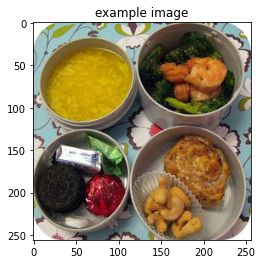

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


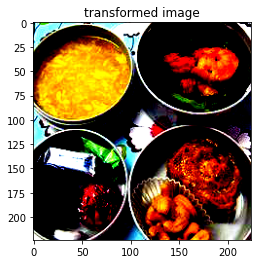

In [ ]:
# Obtain sample image before and after pre-processing
orig_image, image = next(iter(data_loader))
# Convert image from torch.FloatTensor to numpy ndarray
transformed_image = image.numpy()
# Remove the first dimension which is batch_size euqal to 1
transformed_image = np.squeeze(transformed_image)
transformed_image = transformed_image.transpose((1, 2, 0))

# Visualize sample image, before pre-processing
plt.imshow(np.squeeze(orig_image))
plt.title('example image')
plt.show()
# Visualize sample image, after pre-processing
plt.imshow(transformed_image)
plt.title('transformed image')
plt.show()

In [ ]:
checkpoint = torch.load(os.path.join('C:/Users/PC/Desktop/COCO/models', 'best-model.pkl'))


embed_size = 256
hidden_size = 512


vocab = data_loader.dataset.vocab
vocab_size = len(vocab)


encoder = EncoderCNN(embed_size)
encoder.eval()
decoder = DecoderRNN(embed_size, hidden_size, vocab_size)
decoder.eval()


encoder.load_state_dict(checkpoint['encoder'])
decoder.load_state_dict(checkpoint['decoder'])

if torch.cuda.is_available():
    encoder.cuda()
    decoder.cuda()

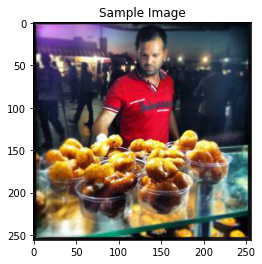

Caption without beam search:
a woman in a yellow shirt and a yellow umbrella
Top captions using beam search:
a woman standing in front of a display of oranges .
a woman standing in front of a display of oranges .
a woman standing in front of a display of oranges .


In [ ]:
get_prediction(data_loader, encoder, decoder, vocab)